# Homework 2 - Generalized Hough Transform

## Theory

- Task 1： ii)
- Taks 2: A) Triangle

## Programming

Find object in an image using a template:  
![title](data/template.jpg)
![title](data/query.jpg)

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import cv2
import utils
import numpy as np
from matplotlib import pyplot as plt

def nonMaxSuprression(img, d=5):
    """
    Given an image set all values to 0 that are not
    the maximum in this (2d+1,2d+1)-window

    Parameters
    ----------
    img : ndarray
        an image
    d : int
        for each pixels consider the surrounding (2d+1,2d+1)-window

    Returns
    -------
    result : ndarray

    """
    rows,cols = img.shape
    result = np.zeros((rows,cols))
    for i in range(rows):
        for j in range(cols):
            low_y = max(0, i-d)
            low_x = max(0, j-d)
            
            high_y = min(rows, i+d) 
            high_x = min(cols, j+d) 
            
            max_val = img[low_y:high_y,low_x:high_x].max()
            
            if img[i,j] == max_val:
                result[i,j] = max_val
    return result

def rotateAndScale(img, angle, scale):
    """
    Rotate and scale an image

    Parameters
    ----------
    img : ndarray
        an image
    angle : float
        angle given in degrees
    scale : float
        scaling of the image

    Returns
    -------
    result : ndarray
        a distorted image

    """
    
    h, w = img.shape
    (cX, cY) = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D((cX, cY), angle, scale)

    corners = np.array([[0, 0, 1],[0, h, 1], [w, 0, 1], [w, h, 1]]).T
    corners = M @ corners
    
    shift = corners.min(1)
    M[:,2]-= shift    
    
    b = corners.max(1)-corners.min(1)
    result = cv2.warpAffine(img, M, (int(b[0]),int(b[1])))
    return result

def calcDirectionalGrad(img):
    """
    Computes the gradients in x- and y-direction.
    The resulting gradients are stored as complex numbers.

    Parameters
    ----------
    img : ndarray
        an image

    Returns
    -------
    ndarray
        The array is stored in the following format: grad_x+ i*grad_y
    """
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
    
    return sobelx + 1.0j*sobely


def circularShift(img, dx, dy):
    """
    Performs a circular shift and puts the new origin into position (dx,dy)

    Parameters
    ----------
    img : ndarray
        an image
    dx : int
        x coordinate
    dy : int
        y coordinate

    Returns
    -------
    result : ndarray
        image with new center

    """
    img = img.copy()
    result = np.zeros_like(img)
    H,W = img.shape
    x, y = 0, 0
    
    result[:-dy,:-dx] = img[dy:,dx:]
    result[:-dy,-dx:] = img[dy:,:dx]
    result[-dy:,:-dx] = img[:dy,dx:]
    result[-dy:,-dx:] = img[:dy,:dx]
    return result

def calcBinaryMask(img, thresh = 0.3):
    """
    Compute the gradient of an image and compute a binary mask
    based on the threshold. Corresponds to O^B in the slides.

    Parameters
    ----------
    img : ndarray
        an image
    thresh : float
        A threshold value. The default is 0.3.

    Returns
    -------
    binary : ndarray
        A binary image.

    """

    # TODO: 
    # -compute gradients
    data = np.copy(img)
    grad = calcDirectionalGrad(data)
    real_grad = np.abs(grad)

    # -threshold gradients 
    maximum = np.amax(real_grad)
    res = np.where(real_grad > thresh * maximum, np.abs(real_grad), 0)
    return res


def correlation(img, template):
    """
    Compute a correlation of gradients between an image and a template.
    
    Note:
    You should use the formula in the slides using the fourier transform.
    Then you are guaranteed to succeed.
    
    However, you can also compute the correlation directly. 
    The resulting image must have high positive values at positions
    with high correlation.

    Parameters
    ----------
    img : ndarray
        a grayscale image
    template : ndarray
        a grayscale image of the template

    Returns
    -------
    ndarray
        an image containing the correlation between image and template gradients.
    """
    
    # TODO:
    # -compute gradient of the image
    ii = calcDirectionalGrad(img)
    
    # -compute gradient of the template
    oi = calcDirectionalGrad(template)
    ob = calcBinaryMask(template)
    T = oi * ob
    
    # -copy template gradient into larger frame
    x, y = oi.shape
    larger_frame = np.zeros(ii.shape, dtype=complex)
    larger_frame[:x, :y] = np.copy(T)
    circShift = circularShift(larger_frame, y//2, x//2)

    # -normalize template
    normalize = circShift / np.sum(np.abs(circShift))

    # -compute correlation
    corr = np.abs(np.fft.ifft2(np.fft.fft2(ii) * np.fft.fft2(normalize)))
    return corr

def GeneralizedHoughTransform(img, template, angles, scales):
    """
    Compute the generalized hough transform. Given an image and a template.
    
    Parameters
    ----------
    img : ndarray
        A query image
    template : ndarray
        a template image
    angles : list[float]
        A list of angles provided in degrees
    scales : list[float]
        A list of scaling factors

    Returns
    -------
    hough_table : list[(correlation, angle, scaling)]
        The resulting hough table is a list of tuples.
        Each tuple contains the correlation and the corresponding combination
        of angle and scaling factors of the template.
        
        Note the order of these values.
    """
    # TODO:
    # for every combination of angles and scales 
    # -distort template
    # -compute the correlation
    # -store results with parameters in a list
    res = []
    for i in range(len(angles)):
        angle = angles[i]

        for j in range(len(scales)):
            scale = scales[j]       
            dst = rotateAndScale(template, angle=angle, scale=scale)
            corr = correlation(img, dst)
            temp = (corr, angle, scale)
            res.append(temp)
    return res

# Main Program

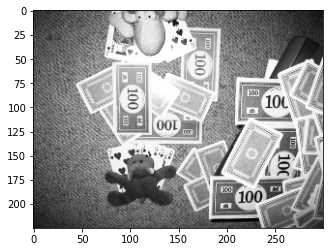

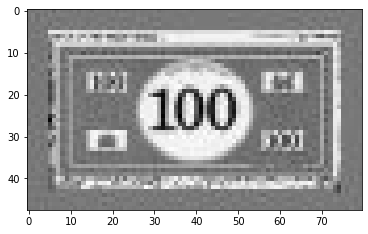

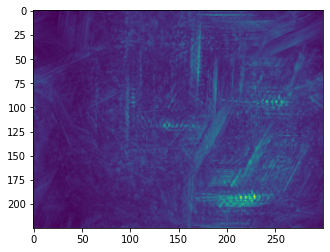

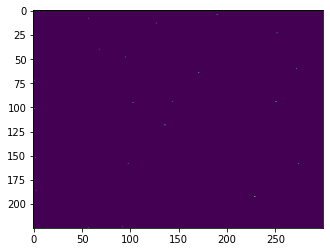

252 23
144 94
272 60
251 94
171 64
229 192
274 158
136 118
190 4
103 95


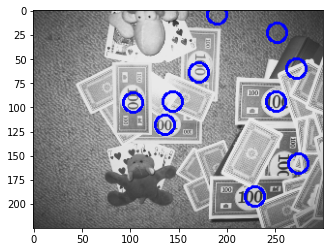

In [2]:
# Load query image and template 
query = cv2.imread("data/query.jpg", cv2.IMREAD_GRAYSCALE)
template = cv2.imread("data/template.jpg", cv2.IMREAD_GRAYSCALE)

# Visualize images
utils.show(query)
utils.show(template)

# Create search space and compute GHT
angles = np.linspace(0, 360, 36)
scales = np.linspace(0.9, 1.3, 10)
ght = GeneralizedHoughTransform(query, template, angles, scales)

# extract votes (correlation) and parameters
votes, thetas, s = zip(*ght)

# Visualize votes
votes = np.stack(votes).max(0)
plt.imshow(votes)
plt.show()

# nonMaxSuprression
votes = nonMaxSuprression(votes, 20)
plt.imshow(votes)
plt.show()

# Visualize n best matches
n = 10
coords = zip(*np.unravel_index(np.argpartition(votes, -n, axis=None)[-n:], votes.shape))
vis = np.stack(3*[query],2)
for y,x in coords:
    print(x,y)
    vis = cv2.circle(vis,(x,y), 10, (255,0,0), 2)
utils.show(vis)


# Test your implementation

In [3]:
import utils
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

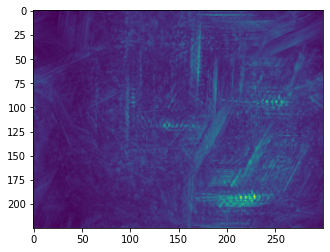

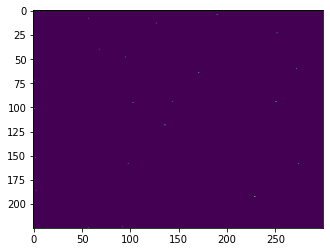

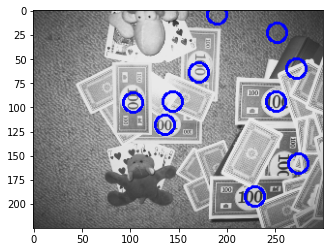

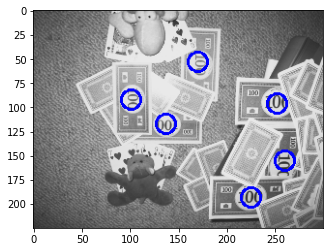

{"scores": {"Correct_Detections": 4}}


In [4]:
from sklearn.metrics.pairwise import euclidean_distances

def testGHT():
    query = cv2.imread("data/query.jpg", cv2.IMREAD_GRAYSCALE)
    template = cv2.imread("data/template.jpg", cv2.IMREAD_GRAYSCALE)
    

    angles = np.linspace(0, 360, 36)
    scales = np.linspace(0.9, 1.3, 10)
    ght = GeneralizedHoughTransform(query, template, angles, scales)
    
    votes, thetas, s = zip(*ght)
    votes = np.stack(votes).max(0)
    plt.imshow(votes)
    plt.show()

    #votes = correlation(query, template)
    votes = nonMaxSuprression(votes, 20)
    plt.imshow(votes)
    plt.show()

    n = 10
    coords = list(zip(*np.unravel_index(np.argpartition(votes, -n, axis=None)[-n:], votes.shape)))

    vis = np.stack(3*[query],2)
    for y,x in coords:
        vis = cv2.circle(vis,(x,y), 10, (255,0,0), 2)
    utils.show(vis)

    f = open("centroids.txt", "r")
    centroids = f.read()
    f.close()
    
    centroids = centroids.split("\n")[:-1]
    centroids = [centroid.split() for centroid in centroids]
    centroids = np.array([[int(centroid[0]),int(centroid[1])] for centroid in centroids])
    
    vis = np.stack(3*[query],2)
    for x,y in centroids:
        vis = cv2.circle(vis,(x,y), 10, (255,0,0), 2)
    utils.show(vis)
    
    coords = np.array(coords)[:,::-1]

    
    d = euclidean_distances(centroids, coords).min(1)
    
    correct_detections = np.count_nonzero((d<10))
    
    score = { "scores": {"Correct_Detections": correct_detections }}
    
    print(json.dumps(score))

testGHT()